In [1]:
import os
%matplotlib inline 
from matplotlib import pyplot as plt
from skimage import io, color, exposure
from skimage.transform import rescale
from skimage.filters import unsharp_mask, sato, frangi, hessian
from skimage.morphology import disk
from skimage.filters import rank
from skimage.measure import moments_central, moments_hu
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score
from skimage.filters import median
import numpy as np
import cv2
import statistics

from scipy import stats

EXTENSION = ".jpg"
EXTENSION_E = ".png"

INPUT = "pictures/obraz1"
INPUT_E = INPUT + "e" + EXTENSION_E
INPUT = INPUT + EXTENSION

INPUT_1 = "pictures/obraz1"
INPUT_1_E = INPUT_1 + "e" + EXTENSION_E
INPUT_1 = INPUT_1 + EXTENSION

INPUT_2 = "pictures/obraz2"
INPUT_2_E = INPUT_2 + "e" + EXTENSION_E
INPUT_2 = INPUT_2 + EXTENSION

SCALE = 1
SLICE_SIZE = 5

### Additional functions

In [2]:
def showImages(img1, img2, img3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

    ax = axes.ravel()

    ax[0].imshow(img1, cmap='gray')
#    ax[0].set_title("Original image")
    
    ax[1].imshow(img2, cmap='gray')
#    ax[1].set_title("Deconvolved, binary")
    
    ax[2].imshow(img3, cmap='gray')
#    ax[2].set_title("Expert")

### Preprocessing

In [3]:
def loadImage(path):
    image = io.imread(path)    
    return image

In [4]:
def scaleImage(image):
    return rescale(image, SCALE, anti_aliasing=True)

In [5]:
def img2grayscale(image):
    return color.rgb2gray(image)

In [6]:
def sharpening(image):
    return unsharp_mask(image, radius=5, amount=2)

In [7]:
def histEq(img):
    return exposure.equalize_adapthist(img, clip_limit=0.01)

In [8]:
def initialProcessing(path):
    img = loadImage(path)
    #Skalowanie i zamiana na skale szarości
    imgNorm = scaleImage(img2grayscale(img))
    #Wyostrzanie obrazu (lepiej widać naczynia)
    imgSharp = sharpening(imgNorm)
    #Local histogram equalization
    imgEqualized = histEq(imgNorm)
    #Logarithmic gamma adjustment
    imgAdjusted = exposure.adjust_log(imgEqualized, 1)
    #showImages(img, imgEqualized, imgAdjusted)
    return (img, imgNorm, imgAdjusted)

In [9]:
(img, imgNorm, image) = initialProcessing(INPUT)

### Vessels finding

In [10]:
def detectVessels(image):
    #def frangi(image, sigmas=range(1, 10, 2), scale_range=None, scale_step=None,
    #       beta1=None, beta2=None, alpha=0.5, beta=0.5, gamma=15,
    #       black_ridges=True)
    image = sato(image)
    #image = frangi(image, gamma=0.15)
    return image

In [11]:
def removeWhiteRing(originalImage, binaryImage):
    for iRow, row in enumerate(originalImage):
        for iPx, px in enumerate(row):
            if px < 0.15:
                binaryImage[iRow][iPx] = 0
    return binaryImage

In [12]:
def loadExpertMask(path):
    expert = io.imread(path)
    expert = scaleImage(expert)
    expert = img2grayscale(expert)
    expert = expert == 1
    expert = expert.astype(int)
    return expert

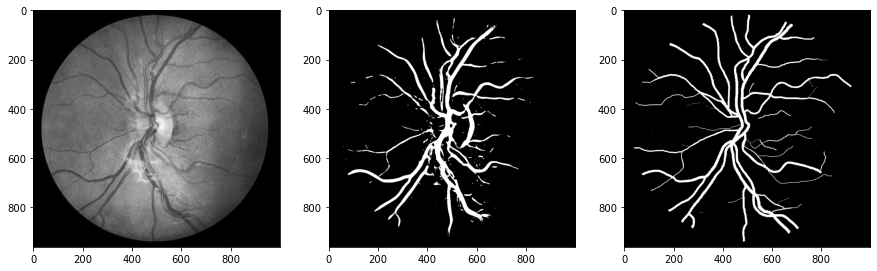

In [13]:
imgVessels = detectVessels(image)

expert = loadExpertMask(INPUT_E)

binary = imgVessels > 0.03
binary = binary.astype(int)

removeWhiteRing(imgNorm, binary)
showImages(image, binary, expert)

### Visualization

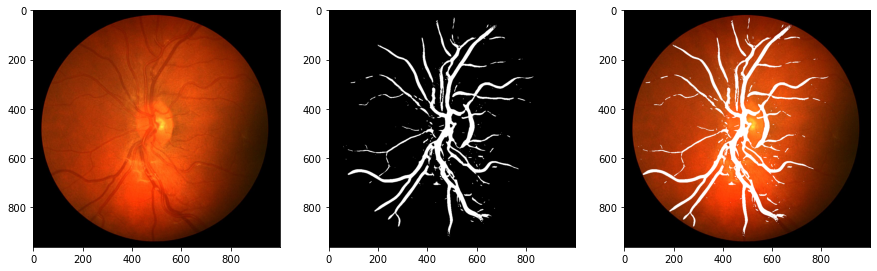

In [14]:
def visualize(originalImage, binaryImage):
    for iRow, row in enumerate(binaryImage):
        for iPx, px in enumerate(row):
            if px == 1:
                originalImage[iRow][iPx] = [255, 255, 255]
    return originalImage

visualized = visualize(img.copy(), binary)
showImages(img, binary, visualized)

### Check correctness

In [15]:
sizeX, sizeY = len(image), len(image[0])

image_positives = int(np.sum(binary))
image_negatives = sizeX * sizeY - image_positives

sizeX, sizeY = len(expert), len(expert[0])

expert_positives = int(np.sum(expert))
expert_negatives = sizeX * sizeY - expert_positives

print(image_positives)
print(image_negatives)

print(expert_positives)
print(expert_negatives)

71852
887188
71068
887972


In [16]:
combination = binary * expert

# TP - correctly classified as positive
# TN -  correctly classified as negative
# FP - incorrectly classified as positive
# FN - incorrectly classified as negative

TP = int(np.sum(combination))
print("Prawdziwie pozytywna: ", TP)

FP = image_positives - TP
print("Fałszywie pozytywna: ", FP)

TN = expert_negatives - FP
print("Prawdziwie negatywna: ", TN)

FN = expert_positives - TP
print("Fałszywie negatywna: ", FN)


Prawdziwie pozytywna:  49530
Fałszywie pozytywna:  22322
Prawdziwie negatywna:  865650
Fałszywie negatywna:  21538


In [17]:
sensitivity = TP / (TP + FN)
print("Czułość: ", sensitivity)

specificity = TN / (TN + FP)
print("Swoistość: ", specificity)

accuracy = (TN + TP) / (TN + TP + FN + FP)
print("Trafność: ", accuracy)

Czułość:  0.6969381437496482
Swoistość:  0.9748618199672963
Trafność:  0.9542667667667668


## 5.0

### Splitting into pieces

In [18]:
class Piece:
    def __init__(self, array, isVessel):
        self.array = array
        self.features = []
        self.computeCentralMoments()
        self.computeHuMoments()
        self.countVariance()
        self.isVessel = 1 if isVessel else 0
    
    def countVariance(self):
        self.features += [statistics.variance(self.array.flatten())]
    
    def computeCentralMoments(self):
        self.features += list(moments_central(self.array).flatten())
        
    def computeHuMoments(self):
        self.features += list(moments_hu(self.array))

In [19]:
def sliceImage(image, mask, pixels):
    middle = int(pixels/2)
    pieces = []
    width = len(image[0])
    height = len(image)
    pieces = []
    for row in range(0, height, pixels):
        for col in range(0, width - 4, pixels):
            #Is middle pixel of mask vessel or not
            if (mask[row:row+pixels,col:col+pixels][middle][middle] == 1): isVessel = True
            else: isVessel = False
            pieces.append(Piece(image[row:row+pixels,col:col+pixels], isVessel))
    return pieces

In [20]:
pieces = sliceImage(image, expert, 5)

In [21]:
def extractDataForClassifier(pieces):
    # moments, variance, etc
    values = []
    # is vessel or not?
    labels = []
    for piece in pieces:
        values.append(piece.features)
        labels.append(piece.isVessel)
    return (values, labels)

In [22]:
#X - list of lists of moments, variances, etc
#y - labels - vessel  or not
X, y = extractDataForClassifier(pieces)

### Cross Validation


In [23]:
# KFold Cross Validation approach
def kFoldCrossValidation (X, y):
    decisionTree = DecisionTreeClassifier()
    kf = KFold(n_splits=5,shuffle=False)
    kf.split(X)

    accuracy_model = []

    # Iterate over each train-test split
    for train_index, test_index in kf.split(X):
        # Split train-test
        X_train, X_test = X[train_index[0]:train_index[-1]], X[test_index[0]:test_index[-1]]
        y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]
        # Train the model
        model = decisionTree.fit(X_train, y_train)
        accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
    return accuracy_model

In [24]:
kFoldCrossValidation(X, y)

[91.23151419971208, 100.0, 100.0, 100.0, 92.22513089005236]

### Two images kfold

In [25]:
# KFold Cross Validation approach
def kFoldCrossValidationTwoImages (X_image_train, y_image_train, X_image_test, y_image_test):
    decisionTree = DecisionTreeClassifier()
    kf = KFold(n_splits=5,shuffle=False)
    kf.split(X_image_train)

    accuracy_model = []

    # Iterate over each train-test split
    for train_index, test_index in kf.split(X_image_train):
        # Split train-test
        X_train, X_test = X_image_train[train_index[0]:train_index[-1]], X_image_test[test_index[0]:test_index[-1]]
        y_train, y_test = y_image_train[train_index[0]:train_index[-1]], y_image_test[test_index[0]:test_index[-1]]
        # Train the model
        model = decisionTree.fit(X_train, y_train)
        accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
    return accuracy_model

In [26]:
(_, _, image_train) = initialProcessing(INPUT_1)
expert_train = loadExpertMask(INPUT_1_E)


pieces_train = sliceImage(image_train, expert_train, SLICE_SIZE)
X_train, y_train = extractDataForClassifier(pieces_train)

(_, _, image_test) = initialProcessing(INPUT_2)
expert_test = loadExpertMask(INPUT_2_E)

pieces_test = sliceImage(image_test, expert_test, SLICE_SIZE)
X_test, y_test = extractDataForClassifier(pieces_test)

In [27]:
kFoldCrossValidationTwoImages(X_train, y_train, X_test, y_test)

[89.46472974741526,
 85.0804868472713,
 84.5308205732234,
 86.40052356020942,
 93.31151832460733]

### ML visualization

In [32]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train, y_train)

predictedImage = decisionTree.predict(X_test)

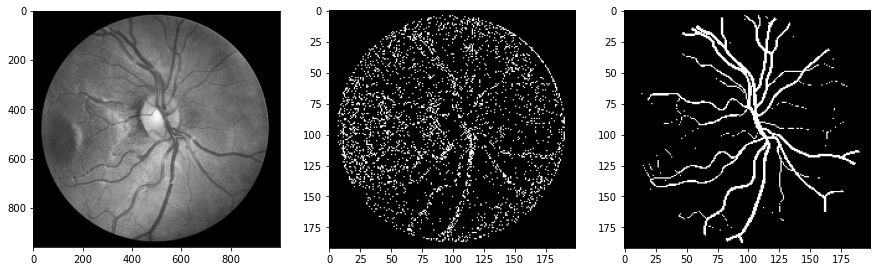

In [35]:
predictedImage = predictedImage.reshape(192, 199)
expertMask = np.array(y_test)
expertMask = expertMask.reshape(192,199)
showImages(image_test, predictedImage, expertMask)